## Install Packages

In [1]:
!conda install -y -c conda-forge faiss-gpu
!apt-get -y update
!apt-get -y install libatlas-base-dev

done
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - faiss-gpu


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.14.0               |   py37h89c1867_0        1010 KB  conda-forge
    toolz-0.12.1               |     pyhd8ed1ab_0          51 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         1.0 MB

The following NEW packages will be INSTALLED:

  toolz              conda-forge/noarch::toolz-0.12.1-pyhd8ed1ab_0

The following packages will be UPDATED:

  conda                               4.12.0-py37h89c1867_0 --> 4.14.0-py37h89c1867_0



toolz-0.12.1         | 51 KB     | ##################################### | 100% 
conda-4.14.0         | 1010 KB   | ##################################### | 100% 
Preparing transaction: done
Ver

## Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.random_projection import GaussianRandomProjection

from tqdm import tqdm

import faiss

In [3]:
df = pd.read_csv("../story_dataset.csv")
df

,prompt_id,prompt,story,hidden_state_file,len_generated_story,len_new_story
0,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Blaz...,./hidden_states/prompt_1.npz,270,271
1,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Spar...,./hidden_states/prompt_1.npz,349,350
2,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Scor...,./hidden_states/prompt_1.npz,278,278
3,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,117,118
4,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,129,130
...,...,...,...,...,...,...
9995,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,289,290
9996,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,119,119
9997,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,127,128
9998,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,441,441


In [4]:
max_story_len = max(df["len_generated_story"])
max_story_len

522

In [5]:
hidden_states_by_layer = {}
NUM_PROMPTS = 10

for prompt_id in range(1, NUM_PROMPTS + 1):
    with np.load(f'../hidden_states/prompt_{prompt_id}.npz') as loaded_data:
        for i in tqdm(range(1000)):
            curr_hidden_states = loaded_data[f"arr_{i}"][0]
#             print(curr_hidden_states.shape)
            for layer in range(7, 8):
                padded_arr = np.zeros((max_story_len, 512))
                padded_arr_len = len(curr_hidden_states[layer][0])
                
                padded_arr[:padded_arr_len] = curr_hidden_states[layer][0]
                
                padded_arr = padded_arr.flatten().astype('float32') #FAISS expects data in type float32 instead of float64 - saves memory too!
#                 print(padded_arr.shape)
                
                if(f"layer_{layer}" in hidden_states_by_layer):
                    hidden_states_by_layer[f"layer_{layer}"].append(padded_arr)
                else:
                    hidden_states_by_layer[f"layer_{layer}"] = [padded_arr]

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 43.53it/s]


In [6]:
layer_hs_array = np.array(hidden_states_by_layer["layer_7"])
layer_hs_array.shape

(10000, 267264)

## Layer 7 Clustering

In [7]:
# Use original vectors for clustering - uncomment next line and comment out last two lines

dim_reduced_vecs = layer_hs_array

# random_projector = GaussianRandomProjection(random_state = 42)
# dim_reduced_vecs = random_projector.fit_transform(layer_hs_array).astype('float32')

In [8]:
dim_reduced_vecs = np.array([v / np.linalg.norm(v) for v in dim_reduced_vecs])
dim_reduced_vecs.shape

(10000, 267264)

In [9]:
prompt_ids = df["prompt_id"]
prompt_ids = prompt_ids.to_numpy()
prompt_ids

array([ 1,  1,  1, ..., 10, 10, 10])

In [10]:
X_train = np.zeros((int(0.8 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_train = np.zeros(int(0.8 * dim_reduced_vecs.shape[0]))

X_test = np.zeros((int(0.2 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_test = np.zeros(int(0.2 * dim_reduced_vecs.shape[0]))

In [11]:
for i in range(10):
    X_train[i * 800 : (i + 1) * 800] = dim_reduced_vecs[i * 1000 : (i * 1000) + 800]
    y_train[i * 800 : (i + 1) * 800] = prompt_ids[i * 1000 : (i * 1000) + 800]
    
    X_test[i * 200 : (i + 1) * 200] = dim_reduced_vecs[(i * 1000) + 800 : (i + 1) * 1000]
    y_test[i * 200 : (i + 1) * 200] = prompt_ids[(i * 1000) + 800 : (i + 1) * 1000]

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8000, 267264)
(8000,)
(2000, 267264)
(2000,)


Sampling a subset of 4000 / 8000 for training
Clustering 4000 points in 267264D to 5 clusters, redo 10 times, 20 iterations
  Preprocessing in 3.65 s
Outer iteration 0 / 10
  Iteration 19 (10.97 s, search 7.36 s): objective=2003.31 imbalance=1.066 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (21.90 s, search 14.67 s): objective=2006.25 imbalance=1.145 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 10
  Iteration 19 (32.83 s, search 22.00 s): objective=2002.14 imbalance=1.033 nsplit=0       
Outer iteration 3 / 10
  Iteration 19 (43.75 s, search 29.30 s): objective=2006.43 imbalance=1.209 nsplit=0       
Objective improved: keep new clusters
Outer iteration 4 / 10
  Iteration 19 (54.72 s, search 36.67 s): objective=1995.85 imbalance=1.503 nsplit=0       
Outer iteration 5 / 10
  Iteration 19 (65.64 s, search 43.98 s): objective=1993.01 imbalance=1.676 nsplit=0       
Outer iteration 6 / 10
  Iteration 19 (76.58 s,

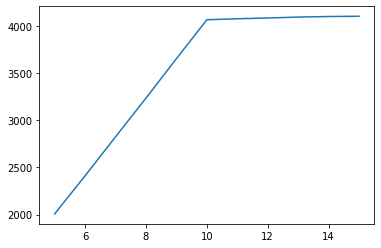

In [13]:
# Elbow Plot
niter = 20
verbose = True
dim = X_train.shape[1]

k_vals = [k for k in range(5, 16)]
wccs = []
for k in k_vals:
    kmeans = faiss.Kmeans(dim, k, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
    kmeans.train(X_train)
    wccs.append(kmeans.obj[-1])

plt.plot(k_vals, wccs)

In [14]:
# K-means Clustering

# ncentroids = NUM_PROMPTS
ncentroids = 10 # Elbow point - based on objective (sum of cosine similarities)
niter = 20
verbose = True
dim = X_train.shape[1]
kmeans = faiss.Kmeans(dim, ncentroids, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
kmeans.train(X_train)


Clustering 8000 points in 267264D to 10 clusters, redo 10 times, 20 iterations
  Preprocessing in 1.12 s
Outer iteration 0 / 10
  Iteration 19 (21.88 s, search 14.71 s): objective=4048.85 imbalance=1.533 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (43.79 s, search 29.43 s): objective=4055.99 imbalance=1.146 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 10
  Iteration 19 (65.73 s, search 44.16 s): objective=4059.71 imbalance=1.296 nsplit=0       
Objective improved: keep new clusters
Outer iteration 3 / 10
  Iteration 19 (87.66 s, search 58.86 s): objective=4063.41 imbalance=1.345 nsplit=0       
Objective improved: keep new clusters
Outer iteration 4 / 10
  Iteration 19 (109.61 s, search 73.57 s): objective=4016.56 imbalance=2.498 nsplit=0       
Outer iteration 5 / 10
  Iteration 19 (131.54 s, search 88.29 s): objective=4051.37 imbalance=1.386 nsplit=0       
Outer iteration 6 / 10
  Iteration 19 (153.54 s, s

4063.41064453125

In [15]:
kmeans.centroids #cluster centers

array([[-0.01964761,  0.01537735,  0.00967851, ...,  0.        ,
         0.        ,  0.        ],
       [-0.01805817,  0.01413337,  0.00889554, ...,  0.        ,
         0.        ,  0.        ],
       [-0.01973203,  0.01544343,  0.0097201 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.0223401 ,  0.01748464,  0.01100483, ...,  0.        ,
         0.        ,  0.        ],
       [-0.02271699,  0.01777962,  0.0111905 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.02278414,  0.01783216,  0.01122356, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [16]:
for centroid in kmeans.centroids:
    print(np.linalg.norm(centroid))

1.000031
1.0000105
1.0000163
1.0000151
1.00001
1.0000062
1.0000066
1.0000055
1.0000054
1.0000057


In [17]:
kmeans.obj #inertia at each iteration

array([2306.47021484, 3915.68603516, 4017.34277344, 4034.41796875,
       4040.61181641, 4042.69970703, 4043.3762207 , 4043.59863281,
       4043.75195312, 4044.01025391, 4044.60571289, 4045.66137695,
       4046.68237305, 4046.85131836, 4047.01757812, 4047.61083984,
       4048.67114258, 4048.84301758, 4048.84545898, 4048.84545898,
       2287.14379883, 3911.68212891, 4006.33300781, 4039.5246582 ,
       4045.68945312, 4048.88818359, 4050.33789062, 4051.10546875,
       4051.67602539, 4052.1315918 , 4052.50366211, 4053.11352539,
       4054.63549805, 4055.40551758, 4055.7565918 , 4055.84521484,
       4055.87548828, 4055.93017578, 4055.96923828, 4055.98681641,
       2244.35668945, 3932.74414062, 4024.62939453, 4043.86279297,
       4050.55419922, 4053.18847656, 4054.92431641, 4055.77368164,
       4056.27441406, 4056.71655273, 4057.21850586, 4057.77978516,
       4058.25463867, 4058.62670898, 4058.9609375 , 4059.21826172,
       4059.43505859, 4059.61865234, 4059.69580078, 4059.70874

In [18]:
cos_similarities = X_train @ kmeans.centroids.T
classifications_train = np.argmax(cos_similarities, axis=1)

In [19]:
pd.Series(classifications_train).value_counts()

6    1864
4    1204
1    1093
2    1087
5     618
0     504
9     449
7     436
3     412
8     333
dtype: int64

In [20]:
# Get most common label for each point classified to a centroid (same centroid)
centroid_labels = [np.where(classifications_train == i)[0] for i in range(ncentroids)]
max_label_per_centroid = [int(pd.Series(y_train[centroid_labels[i]]).value_counts().idxmax()) for i in range(ncentroids)]
max_label_per_centroid

[3, 2, 6, 10, 1, 5, 6, 4, 10, 3]

In [21]:
centroid_to_label = {idx : max_label_per_centroid[idx] for idx in range(len(max_label_per_centroid))}

In [22]:
centroid_to_label

{0: 3, 1: 2, 2: 6, 3: 10, 4: 1, 5: 5, 6: 6, 7: 4, 8: 10, 9: 3}

In [23]:
vectorized_map = np.vectorize(centroid_to_label.get)
classifications_to_label = vectorized_map(classifications_train)

classifications_to_label

array([ 6,  6,  6, ..., 10, 10, 10])

In [24]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label[i * 800:(i + 1) * 800] == (i + 1)))

Prompt 1 Accuracy:  0.2125
Prompt 2 Accuracy:  0.20625
Prompt 3 Accuracy:  0.84625
Prompt 4 Accuracy:  0.185
Prompt 5 Accuracy:  0.42375
Prompt 6 Accuracy:  0.60875
Prompt 7 Accuracy:  0.0
Prompt 8 Accuracy:  0.0
Prompt 9 Accuracy:  0.0
Prompt 10 Accuracy:  0.93125


In [25]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label == y_train))

Overall Accuracy:  0.341375


## Perform Inference on Test Set & Collect Test Accuracy

In [26]:
cos_similarities = X_test @ kmeans.centroids.T
classifications_test = np.argmax(cos_similarities, axis=1)

In [27]:
pd.Series(classifications_test).value_counts()

6    490
1    296
2    282
4    261
5    147
0    127
3    113
9    106
7    101
8     77
dtype: int64

In [28]:
classifications_to_label_test = vectorized_map(classifications_test)

classifications_to_label_test

array([ 6,  2,  3, ..., 10, 10, 10])

In [29]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label_test[i * 200:(i + 1) * 200] == (i + 1)))

Prompt 1 Accuracy:  0.135
Prompt 2 Accuracy:  0.2
Prompt 3 Accuracy:  0.815
Prompt 4 Accuracy:  0.16
Prompt 5 Accuracy:  0.465
Prompt 6 Accuracy:  0.575
Prompt 7 Accuracy:  0.0
Prompt 8 Accuracy:  0.0
Prompt 9 Accuracy:  0.0
Prompt 10 Accuracy:  0.95


In [30]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label_test == y_test))

Overall Accuracy:  0.33


## Confusion Matrix of Results

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

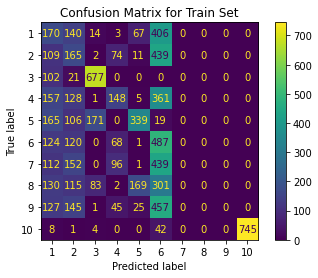

In [32]:
cm = confusion_matrix(y_train, classifications_to_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Train Set')
plt.show()

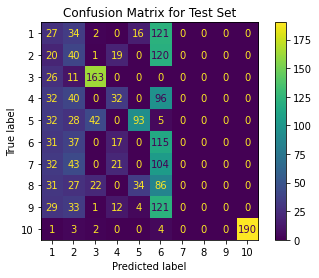

In [33]:
cm = confusion_matrix(y_test, classifications_to_label_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Test Set')
plt.show()